MainProcess


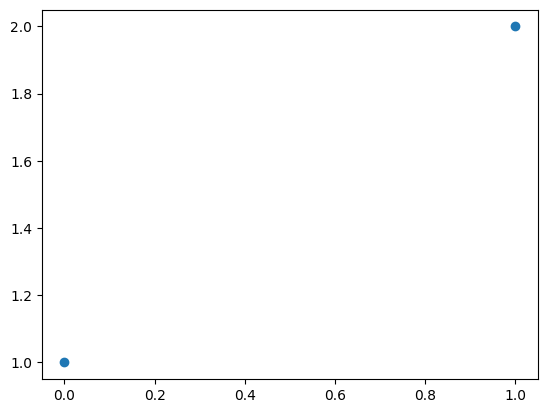

In [1]:
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core')
sys.path.append('/kaggle/input/my-flg-library/')
import flg_support as fls
import importlib
import numpy as np
import flg_diagnostics
import flg_numerics
import matplotlib.pyplot as plt
import glob
import copy
import flg_preprocess
import os
import flg_model
fls.profiling=False
plt.scatter([0,1],[1,2])

In [7]:
files = glob.glob(fls.result_dir + '/many_full_res/Baseline_1002_*')
assert len(files)==1
loaded_data = fls.dill_load(files[0])
test_data = loaded_data.test_data[25:35]

In [ ]:
highest_false_score = []
real_score = []
data_list = []
for i_type in range(8):
    base_model = copy.deepcopy(loaded_data.trained_model)
    base_model.step1Labels.n_ensemble=1
    base_model.step1Labels.trained_model = base_model.step1Labels.trained_model[0:1]
    #model.step1Labels.n_epochs = 2
    #m.step2Motors.distance_threshold = 10.
    if i_type == 0:
        # baseline
        model = base_model     
    elif i_type==1:
        # other seed
        model.step1Labels.trained_model = loaded_data.trained_model.step1Labels.trained_model[1:2]
    elif i_type==2:
        model.step1Labels.preprocessor.voxel_scale = 0.9
    elif i_type==3:
        model.step1Labels.preprocessor.voxel_scale = 0.8
    elif i_type==4:
        model.step1Labels.preprocessor.blur_xy *= 0.5
    elif i_type==5:
        model.step1Labels.preprocessor.blur_xy *= 1.5   
    elif i_type==6:
        model.step1Labels.preprocessor.clip_value = 2.
    elif i_type==7:
        model.step1Labels.preprocessor.clip_value = 3.
    data_file = fls.temp_dir + 'data_tta_' + str(i_type) + '.pickle'
    model.step1Labels.relative_confidence_threshold = 0.01
    if not os.path.isfile(data_file):        
        inferred_data = model.infer(test_data)
        for d in inferred_data:
            d.labels_unfiltered = d.labels_unfiltered2 
        fls.mark_tf_pn(inferred_data, test_data)
        fls.dill_save(data_file, inferred_data)        
    inferred_data = fls.dill_load(data_file)       
    data_list.append(inferred_data)
    this_highest_false_score = []
    this_real_score = []
    for i,r in zip(inferred_data, test_data):
        false_positives = i.labels_unfiltered[i.labels_unfiltered['tf_pn']==1.]
        if len(false_positives)>0:
            this_highest_false_score.append(np.max(false_positives['confidence']))
        else:
            this_highest_false_score.append(0)
        if len(r.labels)>0:
            true_positives = i.labels_unfiltered[i.labels_unfiltered['tf_pn']==0.]
            if len(true_positives)>0:
                this_real_score.append(np.max(true_positives['confidence']))
            else:
                this_real_score.append(0)
    highest_false_score.append(this_highest_false_score)
    real_score.append(this_real_score)


In [ ]:
for d in data_list:
    n_corr=0
    n_total=0
    for i,r in zip(d,test_data):
        if len(r.labels)>0:# and 'tom' in r.name:
            n_total+=1
            ind = np.argmax(i.labels_unfiltered['confidence'])
            if (i.labels_unfiltered['tf_pn'].tolist()[ind])==0.:
                n_corr += 1
    print(n_corr/n_total)
    #print(i.labels_unfiltered)

In [ ]:
i_baseline = 0
for i_new in np.arange(1,len(highest_false_score)):
    _,ax=plt.subplots(1,2,figsize=(10,5))
    plt.sca(ax[0])
    plt.scatter(highest_false_score[i_baseline], highest_false_score[i_new])
    plt.xlabel('Highest false score baseline')
    plt.ylabel('Highest false score new')
    plt.grid(True)
    plt.axline((0,0),slope=1)
    plt.sca(ax[1])
    plt.scatter(real_score[i_baseline], real_score[i_new])
    plt.xlabel('True score baseline')
    plt.ylabel('True score new')
    plt.grid(True)
    plt.axline((0,0),slope=1)
    plt.suptitle(str(i_new))

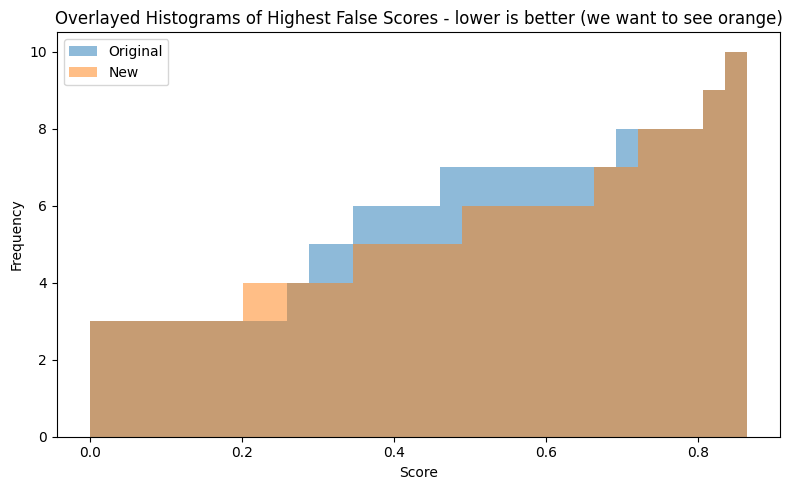

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# flatten the two arrays into one to get global bin edges
all_scores = np.concatenate([highest_false_score[i_baseline], highest_false_score[i_new]])
# choose number of bins (e.g. 30) or compute automatically
bins = np.histogram_bin_edges(all_scores, bins=30)

plt.figure(figsize=(8, 5))
plt.hist(highest_false_score[i_baseline], bins=bins, cumulative=True, alpha=0.5, label='Original')
plt.hist(highest_false_score[i_new], bins=bins, cumulative=True, alpha=0.5, label='New')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Overlayed Histograms of Highest False Scores - lower is better (we want to see orange)')
plt.legend()
plt.tight_layout()
plt.show()

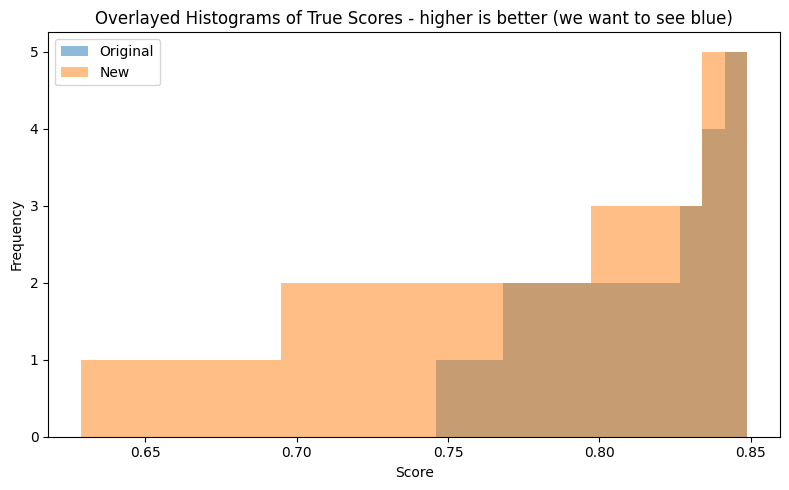

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# flatten the two arrays into one to get global bin edges
all_scores = np.concatenate([real_score[i_baseline], real_score[i_new]])
# choose number of bins (e.g. 30) or compute automatically
bins = np.histogram_bin_edges(all_scores, bins=30)

plt.figure(figsize=(8, 5))
plt.hist(real_score[i_baseline], bins=bins, cumulative=True, alpha=0.5, label='Original')
plt.hist(real_score[i_new], bins=bins, cumulative=True, alpha=0.5, label='New')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Overlayed Histograms of True Scores - higher is better (we want to see blue)')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
def visualize_fp_fn(data, threshold_fp, threshold_fn):

    all_data = fls.load_all_train_data() + fls.load_all_extra_data()
    def visualize_slice(name, z,y,x, color, title_str):
        for d in all_data:
            if d.name == name:
                break
        else:
            raise 'Not found'
        d = copy.deepcopy(d)
        prep = flg_preprocess.Preprocessor2()
        prep.load_and_preprocess(d, desired_original_slices = [z])

        plt.figure()
        plt.imshow(d.data[0,:,:], cmap='bone')
        plt.colorbar()
        plt.title(title_str + ': ' + name + ', ' + str(z))

        plt.scatter([x*d.resize_factor], [y*d.resize_factor], alpha=0.3, color=color, s=200)
    
    for d in data:  
        if not 'tom' in d.name:
            continue
        lab = copy.deepcopy(d.labels_unfiltered).reset_index()

        # false negatives
        if not np.any(np.logical_and(lab['tf_pn']==0., lab['confidence']>threshold_fn)):
            for r in all_data:
                if r.name == d.name:
                    break
            else:
                raise 'Not found'
            if len(r.labels)>0:
                attempts = lab[lab['tf_pn']==0.]
                if len(attempts)>0:
                    thresh = np.max(attempts['confidence'])
                else:
                    thresh = 0.
                visualize_slice(d.name, np.round(r.labels['z'][0]).astype(int),r.labels['y'][0],r.labels['x'][0], 'blue', 'False negative: '+str(thresh))

        # false positives
        slices_done = []
        for i_row in range(len(lab)):
            if lab['tf_pn'][i_row]==1. and lab['confidence'][i_row]>threshold_fp and lab['z'][i_row] not in slices_done:
                #print('fp', d.name, lab['z'][i_row], lab['confidence'][i_row])
                visualize_slice(d.name, lab['z'][i_row],lab['y'][i_row],lab['x'][i_row], 'red', 'False positive ' + str(lab['confidence'][i_row]))
                for ii in np.arange(lab['z'][i_row]-10, lab['z'][i_row]+11):
                    slices_done.append(ii)
#visualize_fp_fn(data_list[i_new], 0.8, 0.8)